In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D)
from tensorflow.keras.layers import MultiHeadAttention, Add
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
from tensorflow.keras.layers import Layer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
import time
import tracemalloc

In [2]:
file_path = r'C:\Users\Χριστόδουλος\Desktop\ML project\cleaned_energy_data.csv'
df = pd.read_csv(file_path)

In [3]:
class PositionalEncoding(Layer):
    def __init__(self, max_len, embed_dim, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.max_len = max_len
        self.embed_dim = embed_dim
        self.pos_encoding = self.positional_encoding(max_len, embed_dim)

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'max_len': self.max_len,
            'embed_dim': self.embed_dim,
        })
        return config

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model
        )
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(
            10000,
            (2 * (i // 2)) / np.float32(d_model)
        )
        return pos * angle_rates

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        return inputs + self.pos_encoding[:, :seq_len, :]

In [4]:
def generate_time_series(n_timesteps):
    x = np.arange(n_timesteps)
    y = np.sin(0.02 * x) + np.random.normal(scale=0.5, size=n_timesteps)
    return y

In [5]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)

    x_ff = Dense(embed_dim, activation='relu')(x)
    x_ff = Dense(embed_dim)(x_ff)
    x = Add()([x_ff, x])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

In [6]:
n_timesteps = 1000
look_back = 46
batch_size = 8
epochs = 20

series = generate_time_series(n_timesteps)

In [7]:
X = df.drop(columns=["Appliances", "date"])
X = X.select_dtypes(include=[np.number])

y = df["Appliances"].astype(float)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

if len(X.shape) == 2:
    X = X.reshape((X.shape[0], X.shape[1], 1))

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [8]:
input_shape = X_train.shape[1:]
inputs = Input(shape=input_shape)

embed_dim = 32
x = Dense(embed_dim)(inputs)

x = PositionalEncoding(max_len=look_back, embed_dim=embed_dim)(x)

x = transformer_encoder(x, head_size=embed_dim, num_heads=4, ff_dim=128, dropout=0.1)
x = transformer_encoder(x, head_size=embed_dim, num_heads=4, ff_dim=128, dropout=0.1)

x = GlobalAveragePooling1D()(x)

outputs = Dense(1)(x)

In [9]:
model = Model(inputs, outputs)
model.compile(
    optimizer=SGD(learning_rate=1e-4, momentum=0.9),
    loss='mean_squared_error'
)

start_time = time.time()
tracemalloc.start()

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - loss: 3392.0596 - val_loss: 542.5025
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 647.8400 - val_loss: 160.8098
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 450.9001 - val_loss: 102.1474
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 429.1668 - val_loss: 101.1410
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 364.2080 - val_loss: 101.8271
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 924.0472 - val_loss: 105.2139
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1279.4351 - val_loss: 109.0199
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 176.2871 - val_loss: 103.1328
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 915.7230 - val_loss: 100.7863
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 622.4105 - val_loss: 112.5191
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 237.4860 - val_loss: 100.7359
Epoch 12/20
13/

In [10]:
rmse = mean_squared_error(y_test, model.predict(X_test), squared=False)
print(f"Transformer RMSE: {rmse}")
y_pred = model.predict(X_test)
y_pred_flat = y_pred.flatten()

mae = mean_absolute_error(y_test, y_pred_flat)
print(f"MAE: {mae}")

mape = np.mean(np.abs((y_test - y_pred_flat) / y_test)) * 100
print(f"MAPE: {mape}%")

r2 = r2_score(y_test, y_pred_flat)
print(f"R² Score: {r2}")
print("Training time (s):", end_time - start_time)
print("Memory usage (Bytes):", current)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
Transformer RMSE: 10.295335226166063
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
MAE: 8.461538901695839
MAPE: 15.829299573933248%
R² Score: -0.05370433728435042
Training time (s): 19.94522976875305
Memory usage (Bytes): 15929847


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


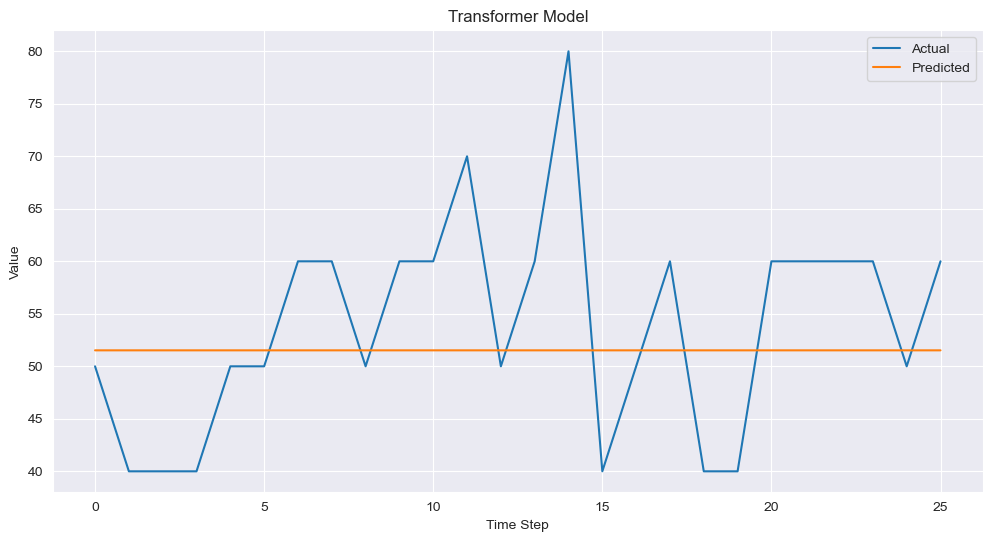

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')  # Ensure y_test is converted to NumPy array
plt.plot(y_pred.flatten(), label='Predicted')
plt.title('Transformer Model')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

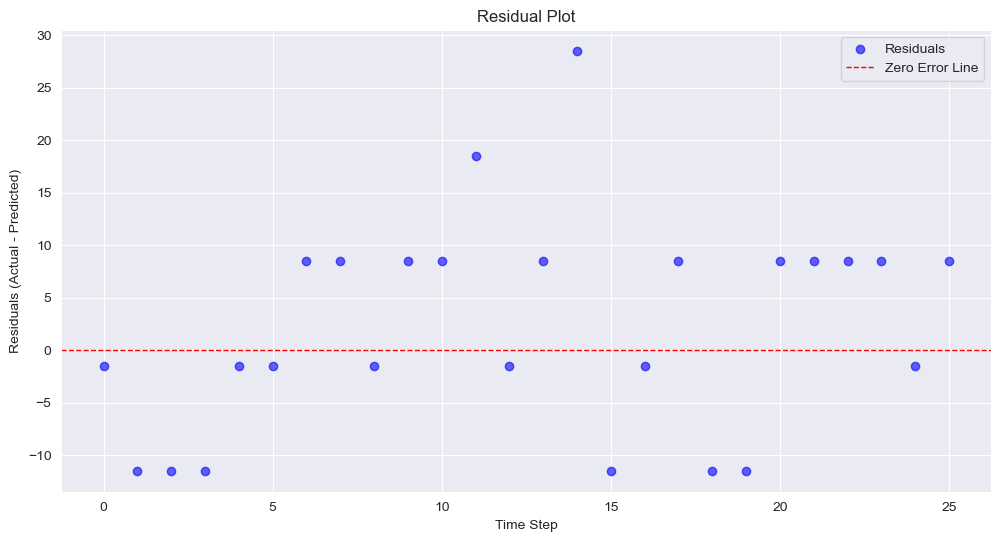

In [12]:
y_test_flat = y_test.reshape(-1) if len(y_test.shape) > 1 else y_test
y_pred_flat = y_pred.reshape(-1) if len(y_pred.shape) > 1 else y_pred

residuals = y_test_flat - y_pred_flat

plt.figure(figsize=(12, 6))
plt.scatter(range(len(residuals)), residuals, color='blue', alpha=0.6, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, label='Zero Error Line')
plt.title('Residual Plot')
plt.xlabel('Time Step')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()